In [1]:
import math
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm.auto import tqdm
from sklearn import metrics
from collections import OrderedDict
torch.manual_seed(914)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load TIMIT Dataset

In [2]:
from datasets import load_dataset

timit = load_dataset('timit_asr')

Reusing dataset timit_asr (C:\Users\Yang\.cache\huggingface\datasets\timit_asr\clean\2.0.1\0d9aa986fc12e3ae76626fd6f835256125ec71c3af4680826359e7e8a98a8176)


In [3]:
timit_train_df = timit["train"].to_pandas()
timit_test_df = timit["test"].to_pandas()

In [4]:
timit_train_df.shape, timit_test_df.shape

((4620, 8), (1680, 8))

In [5]:
timit_train_df.head(10)

,dialect_region,file,id,phonetic_detail,sentence_type,speaker_id,text,word_detail
0,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SI681,"{'start': [0, 1960, 2466, 3480, 4000, 5960, 74...",SI,MMDM0,Would such an act of refusal be useful?,"{'start': [1960, 4000, 9400, 10680, 15880, 182..."
1,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SA2,"{'start': [0, 2120, 2600, 3800, 4344, 7080, 80...",SA,MMDM0,Don't ask me to carry an oily rag like that.,"{'start': [2120, 4344, 8920, 10840, 12280, 180..."
2,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SX411,"{'start': [0, 2130, 2306, 3520, 3920, 5080, 66...",SX,MMDM0,Butterscotch fudge goes well with vanilla ice ...,"{'start': [2130, 12240, 26440, 30200, 35801, 3..."
3,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SA1,"{'start': [0, 2120, 4600, 6558, 8280, 8760, 91...",SA,MMDM0,She had your dark suit in greasy wash water al...,"{'start': [2120, 6558, 9148, 10920, 16560, 212..."
4,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SX231,"{'start': [0, 2280, 4428, 7352, 8229, 10151, 1...",SX,MMDM0,I honor my mom.,"{'start': [2280, 8229, 12040, 15320], 'stop': ..."
5,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SX51,"{'start': [0, 3968, 4428, 5800, 6767, 7268, 74...",SX,MMDM0,Ambidextrous pickpockets accomplish more.,"{'start': [3968, 17560, 28741, 38104], 'stop':..."
6,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SX141,"{'start': [0, 2120, 3000, 3826, 5480, 6892, 74...",SX,MMDM0,Pledge to participate in Nevada's aquatic comp...,"{'start': [2120, 6892, 8520, 19320, 20762, 286..."
7,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SI1941,"{'start': [0, 2040, 2924, 4040, 4920, 5800, 82...",SI,MMDM0,We'll talk over at your office.,"{'start': [2040, 4040, 9817, 14161, 16660, 194..."
8,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SI1311,"{'start': [0, 2680, 5640, 7853, 8647, 10026, 1...",SI,MMDM0,Soil redeposition is evaluated by washing clea...,"{'start': [2680, 8647, 31832, 33420, 46280, 48..."
9,DR4,C:\Users\Yang\.cache\huggingface\datasets\down...,SX321,"{'start': [0, 2920, 3300, 3968, 4440, 5305, 75...",SX,MMDM0,"The groundhog clearly saw his shadow, but stay...","{'start': [2920, 3300, 13160, 18040, 22892, 23..."


# Audio Processing

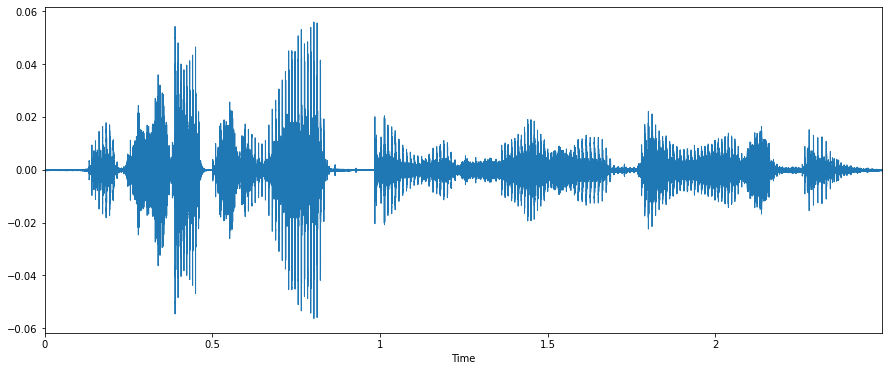

In [6]:
import librosa
import librosa.display

filename = timit_train_df.file[0]
samples, sample_rate = librosa.load(filename, sr=16000)
fig = plt.figure(figsize=(15, 6))
librosa.display.waveplot(samples, sr=sample_rate)

## Padding

In [7]:
from itertools import repeat, chain, islice

def trimmer(seq, size, filler=0):
    return islice(chain(seq, repeat(filler)), size)

In [8]:
sample_rate = 16000

all_wave, all_label = [], []
for idx in tqdm(range(len(timit_train_df))):
    samples, sample_rate = librosa.load(timit_train_df.file[idx], sr=sample_rate)
    samples = list(trimmer(samples, 3*sample_rate))
    label = timit_train_df.speaker_id[idx]
    all_wave.append(samples)
    all_label.append(label)
for idx in tqdm(range(len(timit_test_df))):
    samples, sample_rate = librosa.load(timit_test_df.file[idx], sr=sample_rate)
    samples = list(trimmer(samples, 3*sample_rate))
    label = timit_test_df.speaker_id[idx]
    all_wave.append(samples)
    all_label.append(label)

## Encode Label

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

## MFCC Feature

In [10]:
import python_speech_features

def compute_mfcc(data, n_mfcc, sr=16000):
    print('Compute MFCC, n_mfcc=' + str(n_mfcc), flush=True)
    all_mfcc = []
    for wav in tqdm(data):
        feature = python_speech_features.mfcc(wav, 
                                              samplerate=sr, 
                                              numcep=n_mfcc, 
                                              nfft=int(sr*0.025))
        all_mfcc.append(feature)
    return np.array(all_mfcc)

In [11]:
all_mfcc = compute_mfcc(np.array(all_wave), 20)

Compute MFCC, n_mfcc=20


## Split Dataset

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_mfcc, y, test_size=0.2, random_state=914, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=914, stratify=y_train)
X_train.shape, X_valid.shape, X_test.shape

((3780, 299, 20), (1260, 299, 20), (1260, 299, 20))

## Normalisation

In [13]:
mean_ = np.mean(X_train, axis=0)
std_ = np.std(X_train, axis=0)

In [14]:
X_train = (X_train - mean_) / std_
X_valid = (X_valid - mean_) / std_
X_test = (X_test - mean_) / std_

## Construct Dataset and Dataloader

In [15]:
class SpeechDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index, :, :]
        y = self.y[index]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return [X, y]

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [16]:
train_dataset = SpeechDataset(X=X_train, y=y_train)
valid_dataset = SpeechDataset(X=X_valid, y=y_valid)
test_dataset = SpeechDataset(X=X_test, y=y_test)

batch_size = 128

train_dataloader = train_dataset.create_dataloader(batch_size=batch_size, shuffle=True)
valid_dataloader = valid_dataset.create_dataloader(batch_size=batch_size, shuffle=False)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size, shuffle=False)

In [17]:
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}")

Sample batch:
  X: [128, 299, 20]
  y: [128]


# Setup Trainer

In [18]:
class Engine:

    def __init__(self, model, device, optimiser, scheduler=None, max_epochs=10, patience=10):
        self.model = model
        self.model.to(device)
        self.device = device
        self.optimiser = optimiser
        self.scheduler = scheduler
        self.max_epochs = max_epochs
        self.patience = patience
        
        self.train_losses = []
        self.valid_losses = []
        self.current_train_loss = np.inf
        self.current_valid_loss = np.inf

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)

    def fit(self, train_dataloader, valid_dataloader=None):
        best_loss = np.inf
        early_stopping_counter = 0
        early_stopping_iteration = self.patience
        for epoch in range(self.max_epochs):
            self.current_epoch = epoch
            
            train_loss = self.train_on_epoch(train_dataloader)
            self.current_train_loss = train_loss
            self.train_losses.append(train_loss)
            
            if valid_dataloader is not None:
                valid_loss = self.validation_on_epoch(valid_dataloader)
                self.current_valid_loss = valid_loss
                self.valid_losses.append(valid_loss)
            
            if self.scheduler is not None:
                self.scheduler.step()
            
            if valid_dataloader is not None:
                if valid_loss < best_loss:
                    best_loss = valid_loss
                else:
                    early_stopping_counter += 1

                if early_stopping_counter > early_stopping_iteration:
                    break
    
    def predict_proba(self, test_dataloader):
        # Set model to eval mode
        self.model.eval()
        y_proba = []

        # Iterate over val batches
        with torch.no_grad():
            for x, y in tqdm(test_dataloader, leave=False):
                x, y = x.to(self.device), y.to(self.device)
                proba = self.model(x)
                y_proba.extend(proba.cpu())
        return self.softmax(np.vstack(y_proba))

    @staticmethod
    def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        exp_ = np.exp(x - np.max(x))
        return exp_ / exp_.sum(axis=0)
    
    def train_on_epoch(self, train_dataloader):
        self.model.train()
        final_loss = 0
        pbar = tqdm(train_dataloader, leave=False)
        for counter, (x, y) in enumerate(pbar, start=1):
            pbar.set_description(f'Train Epoch {self.current_epoch}')
            self.optimiser.zero_grad()
            inputs = x.to(self.device)
            targets = y.to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimiser.step()
            final_loss += loss.item()
            pbar.set_postfix({'loss': final_loss/counter})
        return final_loss / len(train_dataloader)

    def validation_on_epoch(self, valid_dataloader):
        self.model.train()
        final_loss = 0
        pbar = tqdm(valid_dataloader, leave=False)
        for counter, (x, y) in enumerate(pbar, start=1):
            pbar.set_description(f'Valid Epoch {self.current_epoch}')
            inputs = x.to(self.device)
            targets = y.to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            final_loss += loss.item()
            pbar.set_postfix({'loss': final_loss/counter})
        return final_loss / len(valid_dataloader)
    
    def find_lr(self, train_dataloader, init_value=1e-8, final_value=10., beta=0.98):
        # Reference from https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html?utm_source=hacpai.com
        num = len(train_dataloader)-1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        self.optimiser.param_groups[0]['lr'] = lr
        avg_loss, best_loss, batch_num = 0., 0., 0
        losses, log_lrs = [], []

        for x, y in tqdm(train_dataloader):
            batch_num += 1
            # Get the loss for this mini-batch of inputs/outputs
            inputs = x.to(self.device)
            targets = y.to(self.device)
            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            # Compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) * loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)
            # Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                log_lrs, losses = log_lrs[10:-5], losses[10:-5]
                return log_lrs, losses
            # Record the best loss
            if smoothed_loss < best_loss or batch_num == 1:
                best_loss = smoothed_loss
            # Store the values
            losses.append(smoothed_loss)
            log_lrs.append(math.log10(lr))
            # Do the SGD step
            loss.backward()
            self.optimiser.step()
            # Update the lr for the next step
            lr *= mult
            self.optimiser.param_groups[0]['lr'] = lr
        
        # The skip of the first 10 values and the last 5 is another thing that the fastai library does by default
        # To remove the initial and final high losses and focus on the interesting parts of the graph.
        log_lrs, losses = log_lrs[10:-5], losses[10:-5]
        
        return log_lrs, losses

# Build Model

In [19]:
class StatsPool(nn.Module):

    def __init__(self, floor=1e-10, bessel=False):
        super(StatsPool, self).__init__()
        self.floor = floor
        self.bessel = bessel

    def forward(self, x):
        means = torch.mean(x, dim=1)
        _, t, _ = x.shape
        if self.bessel:
            t = t - 1
        residuals = x - means.unsqueeze(1)
        numerator = torch.sum(residuals**2, dim=1)
        stds = torch.sqrt(torch.clamp(numerator, min=self.floor)/t)
        x = torch.cat([means, stds], dim=1)
        return x


class TDNN(nn.Module):

    def __init__(
        self,
        input_dim=23,
        output_dim=512,
        context_size=5,
        stride=1,
        dilation=1,
        batch_norm=True,
        dropout_p=0.0,
        padding=0
    ):
        super(TDNN, self).__init__()
        self.context_size = context_size
        self.stride = stride
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dilation = dilation
        self.dropout_p = dropout_p
        self.padding = padding

        self.kernel = nn.Conv1d(self.input_dim,
                                self.output_dim,
                                self.context_size,
                                stride=self.stride,
                                padding=self.padding,
                                dilation=self.dilation)

        self.nonlinearity = nn.ReLU()
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = nn.BatchNorm1d(output_dim)
        self.drop = nn.Dropout(p=self.dropout_p)

    def forward(self, x):
        '''
        input: size (batch, seq_len, input_features)
        outpu: size (batch, new_seq_len, output_features)
        '''
        _, _, d = x.shape
        assert (d == self.input_dim), 'Input dimension was wrong. Expected ({}), got ({})'.format(
            self.input_dim, d)

        x = self.kernel(x.transpose(1, 2))
        x = self.nonlinearity(x)
        x = self.drop(x)

        if self.batch_norm:
            x = self.bn(x)
        return x.transpose(1, 2)
    
class XVectors(nn.Module):
    
    def __init__(
        self,
        dropout_p=0.0, 
        n_classes=30
    ):
        super(XVectors, self).__init__()
        self.tdnn1 = TDNN(input_dim=20, context_size=5, padding=math.floor(5/2))
        self.tdnn2 = TDNN(input_dim=512, context_size=5, padding=math.floor(5/2))
        self.tdnn3 = TDNN(input_dim=512, output_dim=1500, context_size=1, padding=math.floor(1/2))
        self.tdnnres1 = TDNN(input_dim=512, context_size=7, padding=math.floor(7/2))
        self.tdnnres2 = TDNN(input_dim=512, context_size=1, padding=math.floor(1/2))
        self.tdnnres3 = TDNN(input_dim=512, context_size=1, padding=math.floor(1/2))
        self.pool = StatsPool()
        self.linear1 = nn.Linear(3000, 512)
        self.linear2 = nn.Linear(512, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.nonlinearity = nn.ReLU()
        self.classifier = nn.Linear(512, n_classes)
        
    def forward(self, x):
        # Residual TDNN based Frame-level Feature Extractor
        x = self.tdnn1(x)
        x = self.tdnn2(x)
        x = self.tdnnres1(x) + x
        x = self.tdnnres2(x) + x
        x = self.tdnnres3(x) + x
        x = self.tdnn3(x)
        
        # Statistics Pooling
        x = self.pool(x)
        
        # DNN based Segment level Feature Extractor
        x = self.linear1(x)
        x = self.nonlinearity(self.dropout1(self.bn1(x)))
        x = self.linear2(x)
        x = self.nonlinearity(self.dropout2(self.bn2(x)))
        
        # Classifier
        x = self.classifier(x)
        
        return x

## Find Best Learning Rate

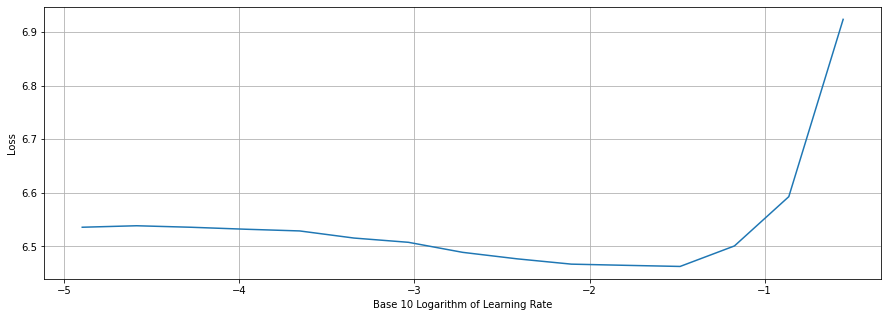

In [20]:
model = XVectors(n_classes=len(classes))
device = "cuda"
optimiser = torch.optim.Adam(model.parameters(), lr=3e-4)
engine = Engine(model, device, optimiser, scheduler=None, max_epochs=100, patience=10)
log_lrs, losses = engine.find_lr(train_dataloader)

plt.figure(figsize=(15, 5))
plt.plot(log_lrs, losses)
plt.xlabel("Base 10 Logarithm of Learning Rate")
plt.ylabel("Loss")
plt.grid()
plt.show()

## Model Training

In [21]:
model = XVectors(n_classes=len(classes), dropout_p=0.2)
device = "cuda"
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=100)
engine = Engine(model, device, optimiser, scheduler=scheduler, max_epochs=100, patience=10)
engine.fit(train_dataloader, valid_dataloader)

In [22]:
test_probs = engine.predict_proba(test_dataloader)
test_preds = np.argmax(test_probs, axis=1)
metrics.f1_score(y_test, test_preds, average="weighted"), metrics.accuracy_score(y_test, test_preds)

(0.9349735449735449, 0.9373015873015873)

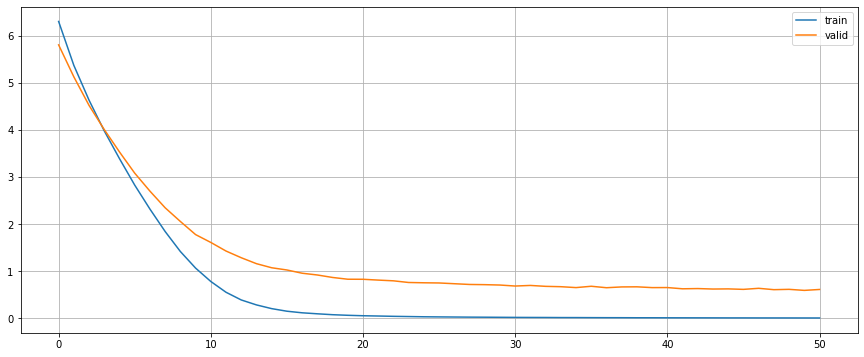

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(engine.train_losses)), engine.train_losses, label="train")
plt.plot(range(len(engine.valid_losses)), engine.valid_losses, label="valid")
plt.legend()
plt.grid()
plt.show()

## Model Training without Validation Dataset

In [24]:
train_valid_dataset = SpeechDataset(
    X=np.concatenate((X_train, X_valid), axis=0), 
    y=np.concatenate((y_train, y_valid), axis=0)
)
train_valid_dataloader = train_valid_dataset.create_dataloader(batch_size=batch_size, shuffle=True)

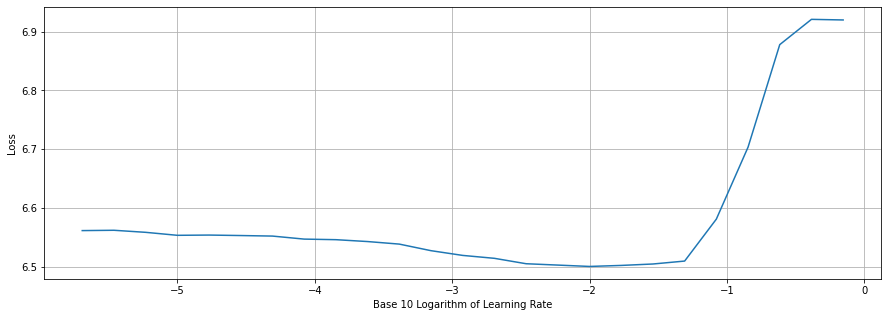

In [25]:
model = XVectors(n_classes=len(classes), dropout_p=0.2)
device = "cuda"
optimiser = torch.optim.Adam(model.parameters(), lr=3e-3)
engine = Engine(model, device, optimiser, scheduler=None, max_epochs=30)
log_lrs, losses = engine.find_lr(train_valid_dataloader)

plt.figure(figsize=(15, 5))
plt.plot(log_lrs, losses)
plt.xlabel("Base 10 Logarithm of Learning Rate")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [26]:
model = XVectors(n_classes=len(classes), dropout_p=0.2)
device = "cuda"
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=100)
engine = Engine(model, device, optimiser, scheduler=scheduler, max_epochs=20, patience=10)
engine.fit(train_valid_dataloader)

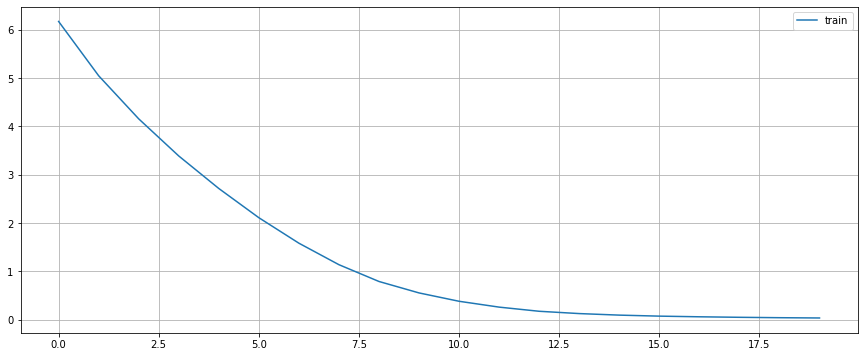

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(engine.train_losses)), engine.train_losses, label="train")
plt.legend()
plt.grid()
plt.show()

In [28]:
test_probs = engine.predict_proba(test_dataloader)
test_preds = np.argmax(test_probs, axis=1)
metrics.f1_score(y_test, test_preds, average="weighted"), metrics.accuracy_score(y_test, test_preds)

(0.9698941798941798, 0.9714285714285714)